## Social Network Analysis with Python

  ================================================================
# EL MAJJODI Ayoub

  ================================================================

***

### Objectives :
- Data wrangling with Python
- Formatting Data for SNA
- SNA with networkx (micro, macro level metrics)
- Network visualization

### 1. Preparing Data 

The first step is getting our Social Network data. For the purpose of this lab we will use the Enron Database. This dataset was collected and prepared by the CALO Project (A Cognitive Assistant that Learns and Organizes). It contains data from about 150 users, mostly senior management of Enron, organized into folders. The corpus contains a total of about 0.5M messages. This data was originally made public, and posted to the web, by the Federal Energy Regulatory Commission during its investigation.

As part of their inquiries, The Federal Energy Regulatory Commission used an extensive collection of emails from Enron employees. The Enron corpus is one of the only publicly available collections of emails available for research. This dataset also provides a fascinating playground for citizen data scientists.


You can download the Database from the following link: http://www.cs.cmu.edu/~enron/


The Original Enron Dataset contains a set of folders that organizes a collection of mailboxes by person and folder. Data wrangling is a routine problem, and this section should give you some perspective and some appreciation for it.



#### Getting all the emails

The main folder is maildir, which holds all the personal accounts. Our first task is to load the required libraries and create a list of available emails. 

You will need to get all files in the inboxes of users. To do that, you need to iterate on all subdirectories 'inbox' within the maildir folder. It is useful to store the path of the files in a data structure before starting to read each file. 

The choice of the inboxes garantees retrieving all possible exchanges, including multi destination emails   

In [1]:
# Import needed libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as ply
import graphviz
import os
import glob
import re

In [2]:
# Get paths to all subdirectories 'inbox'
dires_lst = []
for dires in glob.glob("./maildir/maildir/**/inbox/*" ):
    dires_lst.append(dires)
print(len(dires_lst)," mails")
for i in range(0,10):
    print(dires_lst[i])

41626  mails
./maildir/maildir/hendrickson-s/inbox/19.
./maildir/maildir/hendrickson-s/inbox/46.
./maildir/maildir/hendrickson-s/inbox/63.
./maildir/maildir/hendrickson-s/inbox/68.
./maildir/maildir/hendrickson-s/inbox/31.
./maildir/maildir/hendrickson-s/inbox/65.
./maildir/maildir/hendrickson-s/inbox/49.
./maildir/maildir/hendrickson-s/inbox/57.
./maildir/maildir/hendrickson-s/inbox/39.
./maildir/maildir/hendrickson-s/inbox/58.


We are only interested by Employees who have sent at least one email (i.e. have a subdirectory 'sent'). 

In [3]:
# Keep only Employees who sent emails 
emp_sent  = []  # list contains name of employes who have sent at least one email
tmp_lst = []
path_to_emp = [] # list contains path of each employes
for dires in glob.glob("./maildir/maildir/**/*"):
    a,b,c,d,e = dires.split('/',4)

    tmp_lst = (a,b,c,d)
    try :
        e = str(e)
    except ValueError :
        continue

    if(e == "sent"):
        emp_sent.append(d)
        path_to_emp.append('/'.join(tmp_lst))
        

In [4]:
## The Employes that have sent and Inbox
sent_inbox = []
path_sent_inbox = []
tmp_list = []
emp_name = []
for i in range(len(path_to_emp)):
    for dires in glob.glob(path_to_emp[i]+"/**"):
        a,b,c,d,e = dires.split('/',4)
        tmp_list = (a,b,c,d)
        if(e=="inbox"):
            sent_inbox.append(dires)
            path_sent_inbox.append('/'.join(tmp_list))
            emp_name.append(d)

sent_inbox_df = pd.DataFrame({
    "Name" : emp_name,
    "Path" : path_sent_inbox
})
print("Employees who sent emails :")
sent_inbox_df.head()

Employees who sent emails :


,Name,Path
0,shapiro-r,./maildir/maildir/shapiro-r
1,arora-h,./maildir/maildir/arora-h
2,carson-m,./maildir/maildir/carson-m
3,lokay-m,./maildir/maildir/lokay-m
4,horton-s,./maildir/maildir/horton-s


Make sure to clean your data from any System file etc. Then read the files within the subdirectories. Beware of encoding problems.

In [5]:
# Read all the emails into a dictionary or a data structure of your choice
# You can use the path or username as key and the content of the email as value.
username_email = {}

for i in range(len(path_sent_inbox)):
    for files in glob.glob(path_sent_inbox[i]+"/inbox/1."):
        file = open(files,'r')
        a,b,c,d = path_sent_inbox[i].split('/',3)
        username_email[d] = file.read()

print("Exemple of username and email in inbox dir:")
print("username:",list(username_email.keys())[0],"\nemail:",list(username_email.values())[0])

Exemple of username and email in inbox dir:
username: shapiro-r 
email: Message-ID: <9213955.1075855392905.JavaMail.evans@thyme>
Date: Wed, 26 Dec 2001 11:53:49 -0800 (PST)
From: charles.yeung@enron.com
To: m..presto@enron.com
Subject: RE: FERC Orders Standards Organization by March 15, and OtherMarket
 Design stuff
Cc: l..nicolay@enron.com, d..steffes@enron.com, richard.shapiro@enron.com, 
	doug.gilbert-smith@enron.com, sarah.novosel@enron.com, 
	steve.walton@enron.com, susan.lindberg@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: l..nicolay@enron.com, d..steffes@enron.com, richard.shapiro@enron.com, 
	doug.gilbert-smith@enron.com, sarah.novosel@enron.com, 
	steve.walton@enron.com, susan.lindberg@enron.com
X-From: Yeung, Charles </O=ENRON/OU=NA/CN=RECIPIENTS/CN=CYEUNG>
X-To: Presto, Kevin M. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=KPRESTO>
X-cc: Nicolay, Christi L. </O=ENRON/OU=NA/CN=RECIPIENTS/CN=Cnicola>, Steffes, James D. </O=EN

##### Getting Employees username/emails

We'd also like to get a list of Employees' username (name on the folders) and their emails. Clean your data accordingly. 

Note: You will need to access the first file from each subdirectory 'sent' in order to retrieve the email of an Employee. We use the 'sent' subdirectory because an email can have only one sender but multiple recipients.

You can use Regular Expressions to retrieve the emails from the files.

In [6]:
import timeit
start = start_time = timeit.default_timer()
# Get a list of usernames / emails from Sent emails
emails = []
name = []
path = []
for k in range(len(path_sent_inbox)):
    for first_file in glob.glob(path_sent_inbox[k] + "/sent/*"):
        path.append(first_file)
        file  = open(first_file,'r',encoding="latin-1")
        emails.append(file.read())
        a,b,c,d = path_to_emp[k].split('/',4)
        name.append(d)
print("time = ",timeit.default_timer() - start_time)

time =  84.0830234


The idea here is that, instead of having paths or usernames in your data structure containing the received emails, we will have emails.

You need to transform your data structure using the usernames/emails list you just created, and don't forget to clean your emails in order to only keep strings before the '@' character

In [7]:
# Transform data structure to have emails rather than usernames or paths
user_email = pd.DataFrame({
    "username":name,
    "msg":emails,
    'path':path
})
# user_name / email
user_email.to_csv("./user_email.csv")
path_df = pd.DataFrame({
    'name':path
})
path_df.to_csv("./path.csv")

#### Getting Sender and Receiver information

At this point you have:
- A Data structure containing the email of the destination ('to') and the content of the email
- A list of all usernames / emails

We now need to create a pandas Dataframe (input for our network Analysis) that contains emails of a sender and receiver of every email in your data structure. 

The Dataframe will be created using a list of [sender, receiver].

Note: don't forget to clean your emails in order to only keep strings before the '@' character

In [8]:
# Create a list of [sender, receiver]
# Use Regex to extract the email of the Sender of each email ('From') 
email_from = []
to_email = []

for email,name_f in zip(user_email.msg, user_email.username):
    before,after = email.split('To',1)
    before_sub = after.split('Subject:',1)
    addr = re.findall(r'[\w\.-]+@[\w\.-]+\.\w+',str(before))
    email_from.append(addr)
            # extract the email of the receiver 'to'
    to = re.findall(r'[\w\.-]+@[\w\.-]+\.\w+',str(before_sub[0]))
    to_email.append(to)

##### Creating your Dataframe

Once you have your list, create a pandas Dataframe with two columns 'from' and 'to'.

In [9]:
from_user = []

# Extract name of sender 'From'
for s in email_from:
#for mail in s:
#         m = re.search(r"\[\'([\w\.-]+@[\w\.-]+\.\w+)\'\]",mail)
#         print(m)
#         #add_email = re.search(r"\[\'([\w\.-]+@[\w\.-]+\.\w+)\'\]",str(email)) 
    before, after = str(s).split('@',1) 
    before_tmp = before.replace("['",'')
    from_user.append(before_tmp)

# Extract names of reciver 'to'
to_users = []
for email in to_email:
    before_lst = []
    #print(email)
    for mail in email:
        before, after = str(mail).split('@',1)
        before_lst.append(before)
    to_users.append(before_lst)

Create a pandas Dataframe based on the list. Use pandas documentation if needed

In [10]:
email_from_to = pd.DataFrame({
"From":from_user,
"to":to_users
})
email_from_to.to_csv("./email_from_to.csv")
email_from_to.head()

,From,to
0,richard.shapiro,"[blandford, srosenberg]"
1,richard.shapiro,[steven.kean]
2,richard.shapiro,"[paul.hennemeyer, paul.dawson, peter.styles, d..."
3,richard.shapiro,[orlando.gonzalez]
4,richard.shapiro,[edgillespie]


In [11]:
from_all = []
to_all = []
nbr_email = []
nbr_of_email = 0
for i in range(len(from_user)):
    for j in range(len(to_users[i])):
        from_all.append(from_user[i])
        to_all.append(to_users[i][j])
        nbr_of_email += 1
## The final DataFrame:

final_data= pd.DataFrame({
    "From":from_all,
    "To":to_all
})
final_data.to_csv("./from_to.csv")
final_data.head(20)

,From,To
0,richard.shapiro,blandford
1,richard.shapiro,srosenberg
2,richard.shapiro,steven.kean
3,richard.shapiro,paul.hennemeyer
4,richard.shapiro,paul.dawson
5,richard.shapiro,peter.styles
6,richard.shapiro,doug.wood
7,richard.shapiro,orlando.gonzalez
8,richard.shapiro,edgillespie
9,richard.shapiro,john.sherriff


You Dataframe now contains pairs of 'to', 'from' for every exchanged email.

You can see that some of these pairs are redundant meaning that two people can exchance multiple emails. In order to simplify our graph creation (we could use multigraphs but we rather not), we will add a frequency column to our Dataframe containing the number of exchanges of each pair.

Note: Use groupby

### 2. Creating your Network

At this point, you have a Dataframe with 3 columns 'from', 'to' and 'frequency'

We will now create our network based on the Dataframe. For a preliminary analysis, we will start with an undirected weighted network.

Create a graph, using networkx functions, with frequency as the weight of your edges. 

#### Creating the network

In [12]:
# Create an undirected weighted graph using your Dataframe
G = nx.from_pandas_edgelist(final_data, 'From', 'To')
ply.figure(figsize = (100, 100))

#pos = nx.draw_random(G, node_size = 30, node_color = 'red', edge_color = 'brown', with_labels = True)
ply.savefig('./netw.jpeg')

<Figure size 7200x7200 with 0 Axes>

<img src = "./netss.png" >

Check the network that you just created and compare with your Dataframe. Display the Number of nodes and edges etc.

In [14]:
G1 = G
# Display metrics about your network
info = nx.info(G)
density = nx.density(G)

print("infor :", info)
print("Is G connected :",nx.is_connected(G))


infor : Name: 
Type: Graph
Number of nodes: 8914
Number of edges: 15889
Average degree:   3.5650
Is G connected : False


### 3. Analyzing your Network

#### Calculate network metrics

Perform micro and macro Structural Network Analyses on your email graph.

You can create a dataframe for your node-level metrics.
Display the distribution of your metrics.

We generally chart some of the metrics to get a better look at their values.

Note: It is often a good idea to define functions to calculate your graph's metrics. This makes your code reusable for similar works.


#### Mirco-level analysis


- Degree of each node


In [15]:
from operator import itemgetter

degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(),key =itemgetter(1), reverse=True)

sorted_degree

[('sally.beck', 898),
 ('vince.kaminski', 731),
 ('tana.jones', 730),
 ('jeff.skilling', 635),
 ('jeff.dasovich', 635),
 ('sara.shackleton', 577),
 ('susan.scott', 507),
 ('mark.taylor', 463),
 ('kay.mann', 450),
 ('richard.sanders', 423),
 ('gerald.nemec', 412),
 ('debra.perlingiere', 381),
 ('mike.mcconnell', 375),
 ('sherri.sera', 374),
 ('maureen.mcvicker', 368),
 ('steven.kean', 353),
 ('kay.chapman', 345),
 ('mark.haedicke', 317),
 ('larry.campbell', 296),
 ('chris.germany', 285),
 ('benjamin.rogers', 275),
 ('janette.elbertson', 257),
 ('jeffrey.shankman', 256),
 ('david.delainey', 252),
 ('phillip.love', 252),
 ('elizabeth.sager', 233),
 ('john.lavorato', 211),
 ('rosalee.fleming', 201),
 ('michelle.cash', 201),
 ('patti.thompson', 199),
 ('darron.giron', 199),
 ('john.arnold', 199),
 ('phillip.allen', 199),
 ('beverly.stephens', 195),
 ('daren.farmer', 186),
 ('twanda.sweet', 180),
 ('scott.neal', 174),
 ('eric.bass', 161),
 ('matthew.lenhart', 150),
 ('hunter.shively', 118),


- Degree of centrality

In [16]:
nx.degree_centrality(G)

{'richard.shapiro': 0.0029170874004263436,
 'blandford': 0.00011219566924716706,
 'srosenberg': 0.00011219566924716706,
 'steven.kean': 0.03960507124424997,
 'paul.hennemeyer': 0.00022439133849433412,
 'paul.dawson': 0.00044878267698866825,
 'peter.styles': 0.00044878267698866825,
 'doug.wood': 0.00022439133849433412,
 'orlando.gonzalez': 0.0005609783462358353,
 'edgillespie': 0.00011219566924716706,
 'john.sherriff': 0.001682935038707506,
 'lisa.yoho': 0.0007853696847301694,
 'cbone': 0.00022439133849433412,
 'ginger.dernehl': 0.0006731740154830024,
 'harry.arora': 0.001795130707954673,
 'suresh.raghavan': 0.00022439133849433412,
 'robert.saltiel': 0.00022439133849433412,
 'saji.john': 0.00011219566924716706,
 'jocelyn.gordon': 0.00011219566924716706,
 'leonardo.pacheco': 0.0003365870077415012,
 'carlos.alatorre': 0.0006731740154830024,
 'jeff.bartlett': 0.00022439133849433412,
 'dave.samuels': 0.00044878267698866825,
 'yolanda.roberts': 0.00011219566924716706,
 'mike.carson': 0.00863

- Loacal clustring coeficients

In [17]:
nx.clustering(G)

{'richard.shapiro': 0.28923076923076924,
 'blandford': 0,
 'srosenberg': 0,
 'steven.kean': 0.017094017094017096,
 'paul.hennemeyer': 1.0,
 'paul.dawson': 1.0,
 'peter.styles': 0.8333333333333334,
 'doug.wood': 1.0,
 'orlando.gonzalez': 1.0,
 'edgillespie': 0,
 'john.sherriff': 0.7142857142857143,
 'lisa.yoho': 0.5714285714285714,
 'cbone': 1.0,
 'ginger.dernehl': 0.8,
 'harry.arora': 0.13333333333333333,
 'suresh.raghavan': 1.0,
 'robert.saltiel': 1.0,
 'saji.john': 0,
 'jocelyn.gordon': 0,
 'leonardo.pacheco': 0.3333333333333333,
 'carlos.alatorre': 0.4666666666666667,
 'jeff.bartlett': 0,
 'dave.samuels': 0.3333333333333333,
 'yolanda.roberts': 0,
 'mike.carson': 0.001367053998632946,
 'kenrcars': 0,
 'heather.hill': 0,
 'susan': 0,
 'carson': 0,
 'trpape': 0,
 'tpape': 0,
 'elizabethrhood': 0,
 'mcarson': 0,
 'cjackson': 0,
 'rgibbs': 0,
 'meridetk': 0,
 'macharta': 0,
 'wentapb': 0,
 'jeff.king': 0.2,
 'dttowns': 0,
 'james.mairet': 0,
 'discostars222': 0,
 'john.zufferli': 0.4,
 

- Eigenvector centrality

In [18]:
nx.eigenvector_centrality(G)

{'richard.shapiro': 0.04521156795699854,
 'blandford': 0.000976301601797344,
 'srosenberg': 0.000976301601797344,
 'steven.kean': 0.15295578873767265,
 'paul.hennemeyer': 0.003410750506503168,
 'paul.dawson': 0.009666070380375093,
 'peter.styles': 0.008507337340415864,
 'doug.wood': 0.003410750506503168,
 'orlando.gonzalez': 0.014587728660437307,
 'edgillespie': 0.000976301601797344,
 'john.sherriff': 0.03737344234913197,
 'lisa.yoho': 0.019489458738940136,
 'cbone': 0.004278956133120279,
 'ginger.dernehl': 0.015268460326437775,
 'harry.arora': 0.018576274300086165,
 'suresh.raghavan': 0.0042738639570501355,
 'robert.saltiel': 0.0042738639570501355,
 'saji.john': 0.0004011361001432521,
 'jocelyn.gordon': 0.0004011361001432521,
 'leonardo.pacheco': 0.0076921011849700035,
 'carlos.alatorre': 0.015644060400302983,
 'jeff.bartlett': 0.0057443712542655755,
 'dave.samuels': 0.010597509972433715,
 'yolanda.roberts': 0.0004011361001432521,
 'mike.carson': 0.007547623529213063,
 'kenrcars': 0.0

### Macro-level analysis

- density

In [19]:
nx.density(G)

0.00039997240041916924

- average path lengh

#### Draw the network

In order to get a bird view of the network, we often visualize it using draw functions. Draw your network and choose the best layout to enhance the visualization.   

Networkx offers the possibility of drawing your Graph, but you can choose other libraries (You can even use D3 for interactive visualization).  

You can read the associated documentation or visit their gallery to go further. 

In [ ]:
#In order to visualize your network (and charts) in the same notebook [No new window is opened], use:
%matplotlib inline
# Draw your network

- because we have huge network , we just draw the largest component in the graph

In [ ]:
# get the list of component 
components = nx.connected_components(G)
largest_component = max(components, key = len)

print("the largest component in the graph :\n",largest_component)

In [ ]:
# create subgraph of the largest components
subgraph = G.subgraph(largest_component)
ply.figure(figsize = (100, 100))

pos = nx.draw_random(subgraph, node_size = 10,node_color = 'red', edge_color = 'brown', with_labels = True)

In [ ]:
import json
%matplotlib inline
%matplotlib widget

In [ ]:
# bring this graph to JS
# choose to export the graph to JSon

nodes = [{'name':str(i)} 
       for i in subgraph.nodes()]

links = [{'source':u[0],'target':u[1]}
        for u in subgraph.edges()]
with open('email_sub.json','w') as f:
    json.dump({'nodes':nodes,'links':links},
             f,indent = 4)

In [ ]:
%%html
<div id = "d3-example"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [ ]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width =400, height =400;
  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(70)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("email_sub.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

#### Save the network

Save the resulting network in a 'gexf' file format. 
Save your metrics in a .csv file.

In [20]:
# Save network and metrics for later work
nx.write_gexf(G, "./email.gexf")

### 4. Community detection

In [21]:
# Import the chosen community detection library
# communty API : implements community detection 
import community

- determine the number of communities appropriate for the graph, and assigns each node a number, corresponding to the community it's a member of

In [22]:
communities = community.best_partition(G)
print(communities,10)

{'richard.shapiro': 0, 'blandford': 0, 'srosenberg': 0, 'steven.kean': 0, 'paul.hennemeyer': 0, 'paul.dawson': 0, 'peter.styles': 0, 'doug.wood': 0, 'orlando.gonzalez': 1, 'edgillespie': 0, 'john.sherriff': 2, 'lisa.yoho': 0, 'cbone': 0, 'ginger.dernehl': 0, 'harry.arora': 3, 'suresh.raghavan': 3, 'robert.saltiel': 3, 'saji.john': 3, 'jocelyn.gordon': 3, 'leonardo.pacheco': 0, 'carlos.alatorre': 4, 'jeff.bartlett': 3, 'dave.samuels': 5, 'yolanda.roberts': 3, 'mike.carson': 1, 'kenrcars': 1, 'heather.hill': 1, 'susan': 1, 'carson': 1, 'trpape': 1, 'tpape': 1, 'elizabethrhood': 1, 'mcarson': 1, 'cjackson': 1, 'rgibbs': 6, 'meridetk': 1, 'macharta': 1, 'wentapb': 1, 'jeff.king': 1, 'dttowns': 1, 'james.mairet': 1, 'discostars222': 1, 'john.zufferli': 1, 'matt.lorenz': 5, 'john.berger': 1, 'paul.broderick': 1, 'mark.davis': 1, 'kevin.presto': 1, 'john.suarez': 1, 'chad.starnes': 7, 'clint.dean': 1, 'kyle.schultz': 1, 'rogers.herndon': 1, 'robert.benson': 8, 'doug.gilbert-smith': 1, 'rlmich

- add the partition number to the network

In [23]:
nx.set_node_attributes(G, communities, 'modularity')

/home/aelma/anaconda3/lib/python3.6/site-packages/networkx/drawing/layout.py:499: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


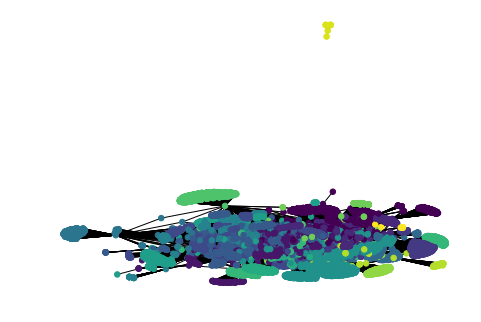

In [24]:
# Visualize your network with nodes colored according to their communities. Use cmap and node_color attributes 
com_value = [communities.get(node) for node in G.nodes()]
nx.draw_spring(G, cmp = ply.get_cmap('jet'), node_color = com_value, node_size = 30, with_labels = False)
ply.savefig('./net_comm.png')

<img src="./net_comm.png">

In [ ]:
# Calculate the performance measure of the chosen partioning method
mod = community.modularity(communities,G)
print("modularity :", mod)

### 5. Core-Periphery

The purpose of this section is to analyze the structure of your network, identify if it has a Core-Periphery structure and if so, inventory all nodes in the core.

Note: Remember that there are many types of Core-periphery structures. Also, a network may have more than one core.

In [ ]:
# Run algorithms and visualizations to identify Core-periphery structure (if existing)

import cpalgorithm as cpa # cpalgorithm contains several 
#algorithms to find core-peripheriy structure

lc = cpa.LapCore() # LapCore algo
lc.detect(G)# detect core-prephirey structure in net